# HARTH — Exploratory Data Analysis (01_eda.ipynb)

Questo notebook:
- scarica il dataset **HARTH** da UCI
- ispeziona file/colonne disponibili
- fa una EDA di base (dimensioni, missing, distribuzione classi, per-soggetto)
- mostra esempi di segnali e correlazioni

> Nota: il dataset è grande (~300MB). La prima esecuzione può richiedere un po’ di tempo.


In [1]:
# (Opzionale) Se siete su Colab: abilita grafici più leggibili
import os, sys, textwrap, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


## 1) Download e unpack del dataset

In [2]:
# Scarica HARTH da UCI (zip) e decomprime in ./data_raw/harth
# Se hai già scaricato in una run precedente, salta automaticamente.

from pathlib import Path
import subprocess

DATA_DIR = Path("data_raw/harth")
DATA_DIR.mkdir(parents=True, exist_ok=True)

zip_path = DATA_DIR / "harth.zip"
url = "https://archive.ics.uci.edu/static/public/779/harth.zip"

if not zip_path.exists():
    print("Downloading HARTH zip...")
    subprocess.run(["bash", "-lc", f"wget -O '{zip_path}' '{url}'"], check=True)
else:
    print("Zip already present:", zip_path)

# unzip (non sovrascrive se già estratto)
marker = DATA_DIR / ".unzipped"
if not marker.exists():
    print("Unzipping...")
    subprocess.run(["bash", "-lc", f"unzip -q '{zip_path}' -d '{DATA_DIR}'"], check=True)
    marker.write_text("ok")
else:
    print("Already unzipped.")

print("Done. Root:", DATA_DIR.resolve())


Unzipping...
Done. Root: /content/data_raw/harth


## 2) Esplora la struttura dei file

In [3]:
# Trova file tabellari (csv/tsv/txt) dentro la cartella
from pathlib import Path

tab_ext = {".csv", ".tsv", ".txt"}
all_files = [p for p in DATA_DIR.rglob("*") if p.is_file()]
tab_files = [p for p in all_files if p.suffix.lower() in tab_ext]

print(f"Totale file: {len(all_files)}")
print(f"File tabellari: {len(tab_files)}")
for p in tab_files[:20]:
    print("-", p.relative_to(DATA_DIR))


Totale file: 24
File tabellari: 22
- harth/S021.csv
- harth/S019.csv
- harth/S008.csv
- harth/S023.csv
- harth/S009.csv
- harth/S027.csv
- harth/S020.csv
- harth/S016.csv
- harth/S017.csv
- harth/S025.csv
- harth/S028.csv
- harth/S018.csv
- harth/S014.csv
- harth/S026.csv
- harth/S010.csv
- harth/S022.csv
- harth/S024.csv
- harth/S015.csv
- harth/S006.csv
- harth/S013.csv


## 3) Caricamento robusto (auto-detect separatore e colonne)

In [4]:
import pandas as pd

def read_table_auto(path: Path, nrows=None) -> pd.DataFrame:
    """Legge un file tabellare provando separatori comuni."""
    # Prova prima comma, poi tab/whitespace
    for sep in [",", "\t", ";"]:
        try:
            df = pd.read_csv(path, sep=sep, nrows=nrows)
            # euristica: deve avere almeno 2 colonne
            if df.shape[1] >= 2:
                return df
        except Exception:
            pass
    # fallback: whitespace
    return pd.read_csv(path, delim_whitespace=True, nrows=nrows)

# Carica un file di esempio per capire le colonne
if len(tab_files) == 0:
    raise RuntimeError("Non trovo file tabellari. Controlla il contenuto della zip.")
sample_path = tab_files[0]
df_sample = read_table_auto(sample_path, nrows=5)
print("Esempio file:", sample_path.relative_to(DATA_DIR))
display(df_sample)
print("Colonne:", list(df_sample.columns))


Esempio file: harth/S021.csv


,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,18655.0,-0.890627,-0.046514,0.155150,-2.487524,0.819993,0.398369,6
1,2019-01-12 00:00:00.020,18656.0,-0.766607,0.007558,0.278709,0.336440,-0.003382,-1.068319,6
2,2019-01-12 00:00:00.040,18657.0,-0.606894,-0.020571,-0.079821,0.593737,-1.517406,-1.337046,6
3,2019-01-12 00:00:00.060,18658.0,-0.590938,0.045517,0.101753,0.188680,-2.725969,-1.339347,6
4,2019-01-12 00:00:00.080,18659.0,-0.444522,0.026991,-0.304779,-1.384996,-1.336540,0.373945,6


Colonne: ['timestamp', 'index', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']


## 4) Costruzione di un DataFrame unico (con colonne standard)

L’idea:
- concatenare più file (es. per soggetto/sessione) in un unico DF
- aggiungere una colonna `source_file` (utile per tracciare l’origine)
- provare a identificare automaticamente:
  - **label** (attività)
  - **subject** (id soggetto), se disponibile in colonna o nel nome file


In [5]:
import re

def infer_subject_from_filename(p: Path):
    # Cerca pattern tipo 'S01', 'subject01', 'sub_01', 'P01' ecc.
    m = re.search(r"(?:sub(?:ject)?|s|p)[_\- ]*(\d+)", p.stem, flags=re.IGNORECASE)
    return int(m.group(1)) if m else None

def pick_label_column(columns):
    # candidati comuni
    cand = ["label", "activity", "act", "class", "y"]
    lower = {c.lower(): c for c in columns}
    for k in cand:
        if k in lower:
            return lower[k]
    # fallback: ultima colonna se è categorica/pochi valori
    return None

def pick_subject_column(columns):
    cand = ["subject", "user", "participant", "person", "sub"]
    lower = {c.lower(): c for c in columns}
    for k in cand:
        if k in lower:
            return lower[k]
    return None

# Per non caricare subito tutto (dataset grande), iniziamo caricando N file
N_FILES = min(6, len(tab_files))   # aumenta se vuoi
dfs = []
for p in tab_files[:N_FILES]:
    df = read_table_auto(p)
    df["source_file"] = str(p.relative_to(DATA_DIR))
    # subject
    subj_col = pick_subject_column(df.columns)
    if subj_col is None:
        df["subject_inferred"] = infer_subject_from_filename(p)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print("Shape (subset):", df.shape)
display(df.head())


Shape (subset): (1469875, 12)


,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,source_file,subject_inferred,Unnamed: 0
0,2019-01-12 00:00:00.000,18655.0,-0.890627,-0.046514,0.155150,-2.487524,0.819993,0.398369,6,harth/S021.csv,21,NaN
1,2019-01-12 00:00:00.020,18656.0,-0.766607,0.007558,0.278709,0.336440,-0.003382,-1.068319,6,harth/S021.csv,21,NaN
2,2019-01-12 00:00:00.040,18657.0,-0.606894,-0.020571,-0.079821,0.593737,-1.517406,-1.337046,6,harth/S021.csv,21,NaN
3,2019-01-12 00:00:00.060,18658.0,-0.590938,0.045517,0.101753,0.188680,-2.725969,-1.339347,6,harth/S021.csv,21,NaN
4,2019-01-12 00:00:00.080,18659.0,-0.444522,0.026991,-0.304779,-1.384996,-1.336540,0.373945,6,harth/S021.csv,21,NaN


## 5) Info base, missing values, tipi di dato

In [6]:
print(df.info())

missing = df.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing rate (solo >0):")
display(missing.to_frame("missing_rate"))

print("\nDescrittive (solo numeriche):")
display(df.describe(include=[np.number]).T.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469875 entries, 0 to 1469874
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   timestamp         1469875 non-null  object 
 1   index             302247 non-null   float64
 2   back_x            1469875 non-null  float64
 3   back_y            1469875 non-null  float64
 4   back_z            1469875 non-null  float64
 5   thigh_x           1469875 non-null  float64
 6   thigh_y           1469875 non-null  float64
 7   thigh_z           1469875 non-null  float64
 8   label             1469875 non-null  int64  
 9   source_file       1469875 non-null  object 
 10  subject_inferred  1469875 non-null  int64  
 11  Unnamed: 0        137646 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 134.6+ MB
None

Missing rate (solo >0):


,missing_rate
Unnamed: 0,0.906355
index,0.794372



Descrittive (solo numeriche):


,count,mean,std,min,25%,50%,75%,max
index,302247.0,172510.006835,89899.134742,18655.000000,94494.500000,171424.000000,249583.500000,329456.000000
back_x,1469875.0,-0.904058,0.458741,-5.682617,-1.016019,-0.973677,-0.812274,1.253294
back_y,1469875.0,0.006388,0.224023,-3.596436,-0.050797,0.015594,0.085571,3.256592
back_z,1469875.0,-0.152959,0.390849,-4.907959,-0.365666,-0.166429,0.084451,4.909483
thigh_x,1469875.0,-0.598250,0.741970,-8.000000,-0.965779,-0.377251,-0.078125,4.457520
thigh_y,1469875.0,0.034617,0.417010,-6.801514,-0.090346,0.072198,0.201625,6.493896
thigh_z,1469875.0,0.377567,0.825153,-8.000000,-0.210566,0.836944,0.949181,7.999756
label,1469875.0,7.133178,11.573219,1.000000,3.000000,7.000000,7.000000,140.000000
subject_inferred,1469875.0,16.462526,6.912800,8.000000,8.000000,19.000000,21.000000,27.000000
Unnamed: 0,137646.0,68822.500000,39735.121914,0.000000,34411.250000,68822.500000,103233.750000,137645.000000


## 6) Distribuzione classi (se troviamo la colonna label)

Label column detected: label


,count
label,
7,675141
1,179548
2,162206
13,143736
6,139353
8,75906
3,48908
4,12300
14,12235


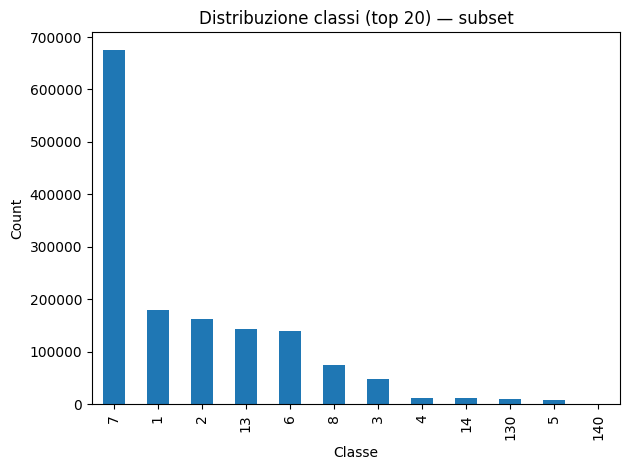

In [7]:
label_col = pick_label_column(df.columns)
print("Label column detected:", label_col)

if label_col is None:
    print("Non riesco a identificare automaticamente la colonna label in questo subset.")
else:
    vc = df[label_col].value_counts(dropna=False)
    display(vc.to_frame("count").head(30))

    plt.figure()
    vc.head(20).plot(kind="bar")
    plt.title("Distribuzione classi (top 20) — subset")
    plt.xlabel("Classe")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## 7) Distribuzione per soggetto (se disponibile)

Subject column used: subject_inferred


,rows
subject_inferred,
8,418989
21,302247
19,297945
27,158584
9,154464
23,137646


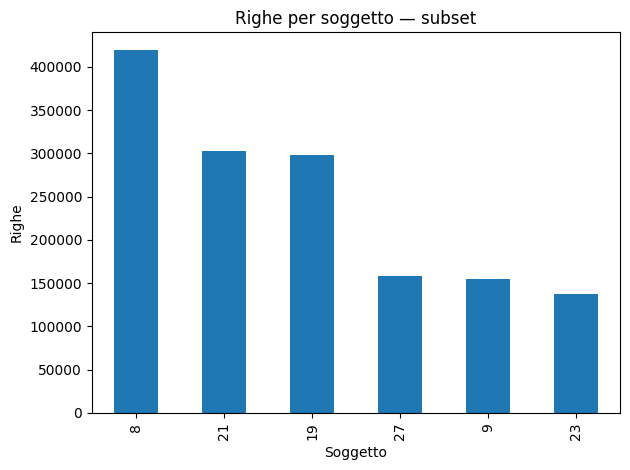

In [8]:
subj_col = pick_subject_column(df.columns)
if subj_col is not None:
    subj = df[subj_col]
elif "subject_inferred" in df.columns:
    subj = df["subject_inferred"]
else:
    subj = None

print("Subject column used:", subj_col if subj_col else ("subject_inferred" if subj is not None else None))

if subj is None:
    print("Non ho trovato informazioni sul soggetto in questo subset.")
else:
    vc_s = subj.value_counts(dropna=False)
    display(vc_s.to_frame("rows").head(30))
    plt.figure()
    vc_s.head(20).plot(kind="bar")
    plt.title("Righe per soggetto — subset")
    plt.xlabel("Soggetto")
    plt.ylabel("Righe")
    plt.tight_layout()
    plt.show()


## 8) Visualizzazione segnali (selezione automatica delle colonne sensore)

Cerchiamo colonne numeriche “tipo IMU” (es. `acc_x`, `acc_y`, `acc_z`...) e plottiamo
un piccolo segmento temporale, eventualmente filtrando per una classe.


Candidate signal columns: ['index', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'Unnamed: 0'] 
Plotting class: 7


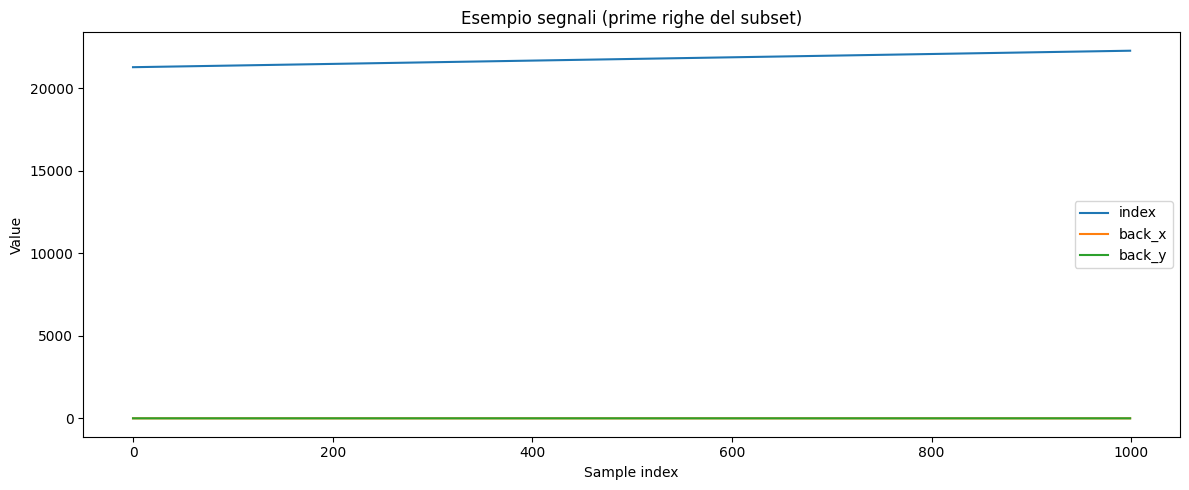

In [9]:
# Selezione colonne numeriche candidate a segnali (escludo label/subject)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
exclude = set([c for c in [label_col, subj_col, "subject_inferred"] if c is not None] + ["source_file"])
signal_cols = [c for c in num_cols if c not in exclude]

print("Candidate signal columns:", signal_cols[:20], "..." if len(signal_cols) > 20 else "")

if len(signal_cols) == 0:
    print("Nessuna colonna numerica candidata trovata nel subset.")
else:
    # Se c'è una label, prendo una classe a caso tra le più frequenti
    df_plot = df.copy()
    if label_col is not None:
        top_class = df_plot[label_col].value_counts().index[0]
        df_plot = df_plot[df_plot[label_col] == top_class]
        print("Plotting class:", top_class)

    # Prendo un segmento di N punti
    N = min(1000, len(df_plot))
    seg = df_plot.iloc[:N]

    plt.figure(figsize=(12, 5))
    # plottiamo fino a 3 segnali per non affollare
    for c in signal_cols[:3]:
        plt.plot(seg[c].to_numpy(), label=c)
    plt.title("Esempio segnali (prime righe del subset)")
    plt.xlabel("Sample index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 9) Correlazioni (subset)

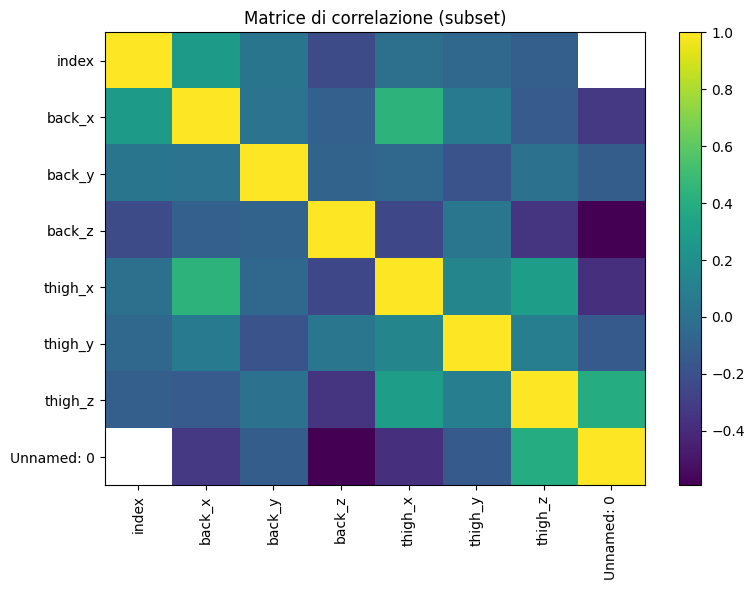

In [10]:
if len(signal_cols) >= 2:
    corr = df[signal_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, aspect="auto")
    plt.title("Matrice di correlazione (subset)")
    plt.xticks(range(len(signal_cols)), signal_cols, rotation=90)
    plt.yticks(range(len(signal_cols)), signal_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Non abbastanza colonne numeriche per la correlazione.")


## 10) (Opzionale) Caricamento completo

Se volete fare EDA sull’intero dataset (più lento), impostate `LOAD_ALL=True`.


In [11]:
LOAD_ALL = False  # <-- metti True se vuoi concatenare tutti i file (più lento e RAM-heavy)

if LOAD_ALL:
    dfs = []
    for p in tab_files:
        try:
            dfi = read_table_auto(p)
            dfi["source_file"] = str(p.relative_to(DATA_DIR))
            subj_col = pick_subject_column(dfi.columns)
            if subj_col is None:
                dfi["subject_inferred"] = infer_subject_from_filename(p)
            dfs.append(dfi)
        except Exception as e:
            print("Skip", p, "err:", e)

    df_all = pd.concat(dfs, ignore_index=True)
    print("Shape (ALL):", df_all.shape)
    display(df_all.head())


# HARTH — Preprocessing & Feature Engineering (02_preprocessing.ipynb)

Obiettivo:
- caricare HARTH (da UCI)
- pulire colonne spurie (`index`, `Unnamed: 0` se presenti)
- creare **finestre temporali** (windowing) per soggetto
- estrarre **feature tabellari** (time-domain) per modelli classici
- salvare un dataset compatto: `X_features`, `y`, `groups(subject)`

Scelte motivate dall’EDA:
- dataset molto grande → evitare training su segnali grezzi
- classi sbilanciate → tenere traccia per metriche/strategie
- distribuzione per soggetto non uniforme → mantenere `groups` per split per soggetto (lo faremo nel notebook modelli)


In [12]:
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)


## 1) Download & unpack (se non già fatto)

In [13]:
import subprocess
import os

DATA_DIR = Path("data_raw/harth")
DATA_DIR.mkdir(parents=True, exist_ok=True)

zip_path = DATA_DIR / "harth.zip"
url = "https://archive.ics.uci.edu/static/public/779/harth.zip"

if not zip_path.exists():
    print(f"Downloading {url} to {zip_path}...")
    subprocess.run(["bash", "-lc", f"wget -O '{zip_path}' '{url}'"], check=True)
else:
    print(f"Zip file already exists at {zip_path}.")

marker = DATA_DIR / ".unzipped"
if not marker.exists():
    try:
        print(f"Unzipping {zip_path} to {DATA_DIR}...")
        subprocess.run(["bash", "-lc", f"unzip -q '{zip_path}' -d '{DATA_DIR}'"], check=True)
        marker.write_text("ok")
        print("Unzipping successful.")
    except subprocess.CalledProcessError as e:
        print(f"Error unzipping file: {e}")
        # If unzipping fails, remove the potentially corrupted zip file and marker
        # so that a fresh download is attempted next time.
        if zip_path.exists():
            os.remove(zip_path)
            print(f"Removed corrupted zip file: {zip_path}")
        if marker.exists():
            os.remove(marker)
            print(f"Removed marker file: {marker}")
        raise # Re-raise the original exception after cleanup
else:
    print(f"Files already unzipped according to marker: {marker}")

csv_files = sorted([p for p in DATA_DIR.rglob("*.csv")])
print("CSV files:", len(csv_files))
print("Esempi:", [str(p.relative_to(DATA_DIR)) for p in csv_files[:5]])

Zip file already exists at data_raw/harth/harth.zip.
Files already unzipped according to marker: data_raw/harth/.unzipped
CSV files: 22
Esempi: ['harth/S006.csv', 'harth/S008.csv', 'harth/S009.csv', 'harth/S010.csv', 'harth/S012.csv']


## 2) Lettura robusta + inferenza soggetto dal filename

In [14]:
def read_csv_safe(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

def infer_subject_from_filename(p: Path) -> int:
    m = re.search(r"(?:sub(?:ject)?|s|p)[_\- ]*(\d+)", p.stem, flags=re.IGNORECASE)
    if not m:
        raise ValueError(f"Cannot infer subject from filename: {p.name}")
    return int(m.group(1))

p0 = csv_files[0]
df0 = read_csv_safe(p0)
sub0 = infer_subject_from_filename(p0)
print("File:", p0.name, "subject:", sub0, "shape:", df0.shape)
display(df0.head())
print("Columns:", list(df0.columns))


File: S006.csv subject: 6 shape: (408709, 8)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


Columns: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']


## 3) Pulizia colonne e parsing timestamp

In [15]:
SENSOR_COLS = ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]
LABEL_COL = "label"
TIME_COL = "timestamp"

def clean_df(df: pd.DataFrame, subject_id: int, source_file: str) -> pd.DataFrame:
    df = df.drop(columns=["index", "Unnamed: 0"], errors="ignore").copy()
    df["subject"] = subject_id
    df["source_file"] = source_file
    if df[TIME_COL].dtype == "object":
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

df0c = clean_df(df0, sub0, str(p0.relative_to(DATA_DIR)))
display(df0c.head())
print(df0c.dtypes)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject,source_file
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6,6,harth/S006.csv
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6,6,harth/S006.csv
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6,6,harth/S006.csv
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6,6,harth/S006.csv
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6,6,harth/S006.csv


timestamp      datetime64[ns]
back_x                float64
back_y                float64
back_z                float64
thigh_x               float64
thigh_y               float64
thigh_z               float64
label                   int64
subject                 int64
source_file            object
dtype: object


## 4) Windowing: parametri consigliati

- Frequenza ~50Hz (EDA)  
- Proposta: **3s** (150 campioni) e **overlap 50%** (step 75)

Gestione transizioni:
- label finestra = **maggioranza**
- opzionale: scartare finestre “sporche” se la maggioranza è < `purity_threshold`


In [16]:
FS = 50
WINDOW_SEC = 3.0
WINDOW_SIZE = int(WINDOW_SEC * FS)  # 150
STEP = WINDOW_SIZE // 2            # 75
PURITY_THRESHOLD = 0.8

WINDOW_SIZE, STEP


(150, 75)

## 5) Feature engineering (time-domain)

In [17]:
def magnitude(x, y, z):
    return np.sqrt(x*x + y*y + z*z)

def compute_features(window: np.ndarray, prefix: str) -> dict:
    feats = {}
    for j in range(window.shape[1]):
        v = window[:, j]
        feats[f"{prefix}{j}_mean"] = float(np.mean(v))
        feats[f"{prefix}{j}_std"]  = float(np.std(v))
        feats[f"{prefix}{j}_min"]  = float(np.min(v))
        feats[f"{prefix}{j}_max"]  = float(np.max(v))
        feats[f"{prefix}{j}_energy"] = float(np.mean(v*v))
    return feats

def featurize_segment(seg: pd.DataFrame) -> dict:
    back = seg[["back_x", "back_y", "back_z"]].to_numpy(dtype=np.float32)
    thigh = seg[["thigh_x", "thigh_y", "thigh_z"]].to_numpy(dtype=np.float32)

    feats = {}
    feats.update(compute_features(back,  "back_"))
    feats.update(compute_features(thigh, "thigh_"))

    back_mag = magnitude(back[:,0], back[:,1], back[:,2]).reshape(-1,1)
    thigh_mag = magnitude(thigh[:,0], thigh[:,1], thigh[:,2]).reshape(-1,1)
    feats.update(compute_features(back_mag,  "back_mag_"))
    feats.update(compute_features(thigh_mag, "thigh_mag_"))
    return feats


## 6) Costruzione dataset finestre → feature (streaming per file)

In [18]:
from collections import Counter

def majority_label(y_window: np.ndarray):
    c = Counter(y_window.tolist())
    lab, cnt = c.most_common(1)[0]
    purity = cnt / len(y_window)
    return lab, purity

def windows_to_features(df: pd.DataFrame,
                        window_size: int = WINDOW_SIZE,
                        step: int = STEP,
                        purity_threshold: float = PURITY_THRESHOLD):
    X_rows, y_rows, g_rows, meta_rows = [], [], [], []
    n = len(df)
    for start in range(0, n - window_size + 1, step):
        seg = df.iloc[start:start+window_size]
        lab, purity = majority_label(seg[LABEL_COL].to_numpy())
        if purity < purity_threshold:
            continue
        X_rows.append(featurize_segment(seg))
        y_rows.append(lab)
        g_rows.append(int(seg["subject"].iloc[0]))
        meta_rows.append({
            "subject": int(seg["subject"].iloc[0]),
            "source_file": seg["source_file"].iloc[0],
            "t_start": seg[TIME_COL].iloc[0],
            "t_end": seg[TIME_COL].iloc[-1],
            "purity": purity
        })
    return X_rows, y_rows, g_rows, meta_rows

X_tmp, y_tmp, g_tmp, meta_tmp = windows_to_features(df0c)
print("Windows kept:", len(y_tmp))
print("Unique labels:", len(set(y_tmp)))
display(pd.Series(y_tmp).value_counts().head(10))


Windows kept: 5033
Unique labels: 10


,count
7,3366
6,697
13,318
1,232
8,172
130,138
3,39
14,38
5,17
4,16


## 7) Esecuzione su tutti i soggetti (può richiedere tempo)

In [19]:
MAX_SUBJECTS = None  # es. 5 per test; None = tutti

X_all, y_all, g_all, meta_all = [], [], [], []
files = csv_files if MAX_SUBJECTS is None else csv_files[:MAX_SUBJECTS]

for p in files:
    sid = infer_subject_from_filename(p)
    dfi = clean_df(read_csv_safe(p), sid, str(p.relative_to(DATA_DIR)))
    missing_cols = [c for c in SENSOR_COLS + [LABEL_COL, TIME_COL] if c not in dfi.columns]
    if missing_cols:
        raise ValueError(f"{p.name}: missing columns {missing_cols}")
    X_rows, y_rows, g_rows, meta_rows = windows_to_features(dfi)
    X_all.extend(X_rows)
    y_all.extend(y_rows)
    g_all.extend(g_rows)
    meta_all.extend(meta_rows)

print("Feature rows:", len(y_all))
print("N subjects:", len(set(g_all)))
print("Class distribution (top):")
display(pd.Series(y_all).value_counts().head(15))


Feature rows: 79467
N subjects: 22
Class distribution (top):


,count
7,38550
1,14331
6,8084
8,5677
13,5091
2,3796
3,1277
4,818
14,667
5,614


## 8) Salvataggio (Parquet)

In [20]:
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

X_df = pd.DataFrame(X_all)
y_ser = pd.Series(y_all, name="label")
g_ser = pd.Series(g_all, name="subject")
meta_df = pd.DataFrame(meta_all)

print("X shape:", X_df.shape, "y:", y_ser.shape, "groups:", g_ser.shape)
display(X_df.head())

X_df.to_parquet(OUT_DIR / "X_features.parquet", index=False)
y_ser.to_frame().to_parquet(OUT_DIR / "y_labels.parquet", index=False)
g_ser.to_frame().to_parquet(OUT_DIR / "groups_subject.parquet", index=False)
meta_df.to_parquet(OUT_DIR / "windows_meta.parquet", index=False)

print("Saved to:", OUT_DIR.resolve())


X shape: (79467, 40) y: (79467,) groups: (79467,)


,back_0_mean,back_0_std,back_0_min,back_0_max,back_0_energy,back_1_mean,back_1_std,back_1_min,back_1_max,back_1_energy,back_2_mean,back_2_std,back_2_min,back_2_max,back_2_energy,thigh_0_mean,thigh_0_std,thigh_0_min,thigh_0_max,thigh_0_energy,thigh_1_mean,thigh_1_std,thigh_1_min,thigh_1_max,thigh_1_energy,thigh_2_mean,thigh_2_std,thigh_2_min,thigh_2_max,thigh_2_energy,back_mag_0_mean,back_mag_0_std,back_mag_0_min,back_mag_0_max,back_mag_0_energy,thigh_mag_0_mean,thigh_mag_0_std,thigh_mag_0_min,thigh_mag_0_max,thigh_mag_0_energy
0,-0.996587,0.038474,-1.272421,-0.952415,0.994665,0.071433,0.040270,-0.028849,0.467094,0.006724,0.066707,0.029406,-0.086133,0.141577,0.005315,-0.960233,0.045125,-1.300614,-0.870048,0.924083,0.073154,0.035164,0.030090,0.302179,0.006588,-0.303720,0.035148,-0.407529,-0.092001,0.093481,1.002417,0.043173,0.953865,1.362819,1.006704,1.011174,0.040989,0.965426,1.308329,1.024152
1,-0.983860,0.065738,-1.413744,-0.802925,0.972301,0.121802,0.103753,-0.192840,0.511083,0.025600,0.089364,0.046876,-0.085015,0.293643,0.010183,-0.993889,0.092250,-1.474092,-0.750604,0.996325,0.080636,0.126504,-0.303226,0.673558,0.022505,-0.221810,0.164835,-0.843538,0.553840,0.076370,1.001768,0.067417,0.858585,1.531699,1.008085,1.040724,0.109971,0.832054,1.500345,1.095201
2,-0.989083,0.006127,-1.003145,-0.980028,0.978323,0.101997,0.014883,0.064781,0.144725,0.010625,0.053265,0.007762,0.033504,0.081632,0.002897,-0.972996,0.004334,-0.989530,-0.955061,0.946740,0.019738,0.014870,-0.026735,0.056641,0.000611,-0.239936,0.012222,-0.275305,-0.207471,0.057719,0.995898,0.005653,0.985843,1.008072,0.991846,1.002521,0.004557,0.986028,1.016500,1.005070
3,-0.986296,0.004684,-1.003145,-0.980028,0.972802,0.109627,0.013354,0.078106,0.144725,0.012196,0.060995,0.009467,0.036793,0.081632,0.003810,-0.973578,0.003340,-0.989530,-0.957548,0.947866,0.013937,0.013086,-0.026735,0.056641,0.000365,-0.231581,0.009787,-0.258725,-0.207471,0.053726,0.994380,0.004229,0.986210,1.010653,0.988809,1.000971,0.003629,0.989470,1.016500,1.001957
4,-0.985436,0.003873,-1.001719,-0.980081,0.971100,0.116225,0.007092,0.101993,0.134631,0.013559,0.065270,0.006989,0.051615,0.086576,0.004309,-0.973808,0.002957,-0.989648,-0.960240,0.948310,0.012621,0.009145,-0.013471,0.027624,0.000243,-0.230910,0.007682,-0.255664,-0.209650,0.053379,0.994460,0.004010,0.988402,1.010903,0.988967,1.000960,0.003245,0.990293,1.018768,1.001932


Saved to: /content/data/processed


## 9) Controlli rapidi

,n_windows
subject,
6,5033
8,5088
9,1940
10,4123
12,4895
13,4375
14,4350
15,5133
16,4373


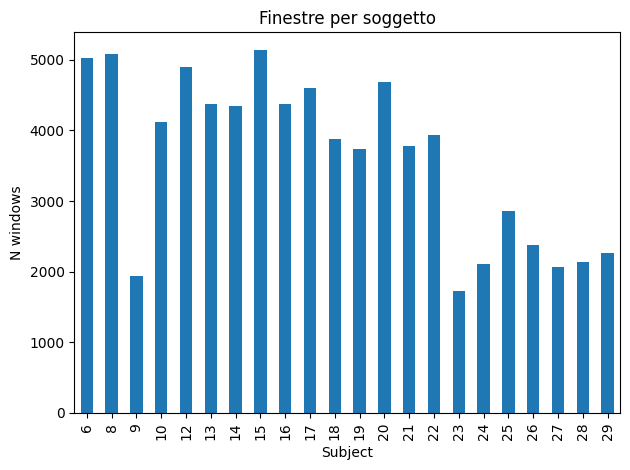

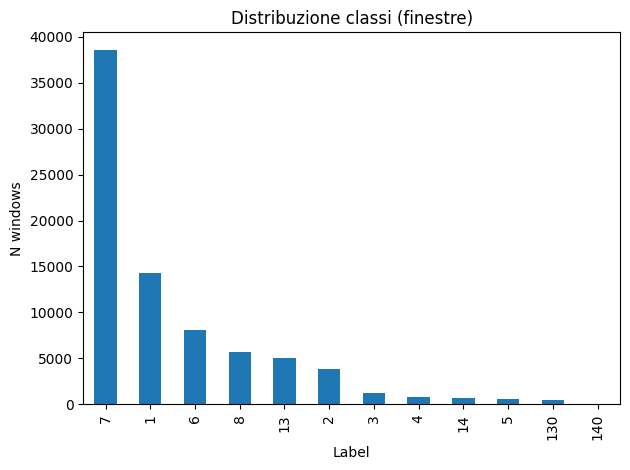

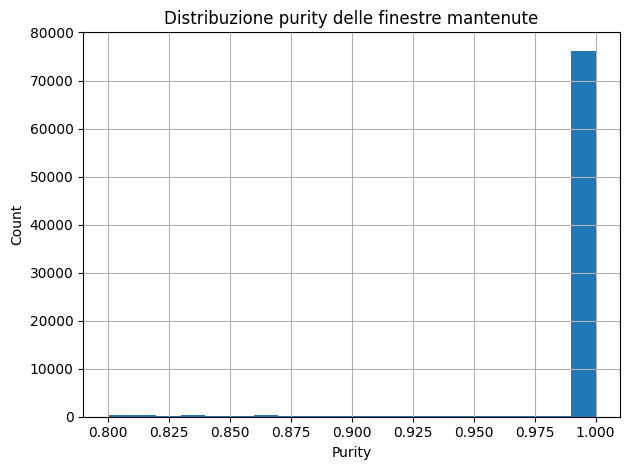

In [21]:
subj_counts = g_ser.value_counts().sort_index()
display(subj_counts.to_frame("n_windows").head(30))

plt.figure()
subj_counts.plot(kind="bar")
plt.title("Finestre per soggetto")
plt.xlabel("Subject")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

class_counts = y_ser.value_counts()
plt.figure()
class_counts.head(20).plot(kind="bar")
plt.title("Distribuzione classi (finestre)")
plt.xlabel("Label")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

if len(meta_df) > 0 and "purity" in meta_df.columns:
    plt.figure()
    meta_df["purity"].hist(bins=20)
    plt.title("Distribuzione purity delle finestre mantenute")
    plt.xlabel("Purity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# HARTH — Models & Evaluation (03_models.ipynb)

Confronto **Logistic Regression (L2) baseline** vs **LDA (shrinkage)** con validazione corretta **per soggetto**.

Ricetta (semplice e “da esame”):
1. Split finale **train/test** con `GroupShuffleSplit` (test = 20% soggetti).
2. Sul solo training: stima robusta con **GroupKFold (k=5)**.
3. Fit finale su tutto il training, valutazione una sola volta sul test.
4. Metriche: **macro-F1**, **balanced accuracy**, **confusion matrix**.

Prerequisito:
- aver eseguito `02_preprocessing.ipynb`, che salva:
  - `data/processed/X_features.parquet`
  - `data/processed/y_labels.parquet`
  - `data/processed/groups_subject.parquet`


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)


## 1) Caricamento dataset preprocessato

In [23]:
!ls -la data/processed

total 23152
drwxr-xr-x 2 root root     4096 Jan 31 14:19 .
drwxr-xr-x 3 root root     4096 Jan 31 14:19 ..
-rw-r--r-- 1 root root     1335 Jan 31 14:19 groups_subject.parquet
-rw-r--r-- 1 root root  1356538 Jan 31 14:19 windows_meta.parquet
-rw-r--r-- 1 root root 22326183 Jan 31 14:19 X_features.parquet
-rw-r--r-- 1 root root     6666 Jan 31 14:19 y_labels.parquet


In [24]:
DATA_DIR = Path("data/processed")
X_path = DATA_DIR / "X_features.parquet"
y_path = DATA_DIR / "y_labels.parquet"
g_path = DATA_DIR / "groups_subject.parquet"

if not (X_path.exists() and y_path.exists() and g_path.exists()):
    raise FileNotFoundError(
        "File preprocessati non trovati. Esegui prima 02_preprocessing.ipynb per generare i parquet in data/processed/."
    )

X = pd.read_parquet(X_path)
y = pd.read_parquet(y_path).iloc[:, 0]      # colonna 'label'
groups = pd.read_parquet(g_path).iloc[:, 0] # colonna 'subject'

print("X:", X.shape, "y:", y.shape, "groups:", groups.shape)
print("N soggetti:", groups.nunique(), "N classi:", y.nunique())
display(X.head())


X: (79467, 40) y: (79467,) groups: (79467,)
N soggetti: 22 N classi: 12


,back_0_mean,back_0_std,back_0_min,back_0_max,back_0_energy,back_1_mean,back_1_std,back_1_min,back_1_max,back_1_energy,back_2_mean,back_2_std,back_2_min,back_2_max,back_2_energy,thigh_0_mean,thigh_0_std,thigh_0_min,thigh_0_max,thigh_0_energy,thigh_1_mean,thigh_1_std,thigh_1_min,thigh_1_max,thigh_1_energy,thigh_2_mean,thigh_2_std,thigh_2_min,thigh_2_max,thigh_2_energy,back_mag_0_mean,back_mag_0_std,back_mag_0_min,back_mag_0_max,back_mag_0_energy,thigh_mag_0_mean,thigh_mag_0_std,thigh_mag_0_min,thigh_mag_0_max,thigh_mag_0_energy
0,-0.996587,0.038474,-1.272421,-0.952415,0.994665,0.071433,0.040270,-0.028849,0.467094,0.006724,0.066707,0.029406,-0.086133,0.141577,0.005315,-0.960233,0.045125,-1.300614,-0.870048,0.924083,0.073154,0.035164,0.030090,0.302179,0.006588,-0.303720,0.035148,-0.407529,-0.092001,0.093481,1.002417,0.043173,0.953865,1.362819,1.006704,1.011174,0.040989,0.965426,1.308329,1.024152
1,-0.983860,0.065738,-1.413744,-0.802925,0.972301,0.121802,0.103753,-0.192840,0.511083,0.025600,0.089364,0.046876,-0.085015,0.293643,0.010183,-0.993889,0.092250,-1.474092,-0.750604,0.996325,0.080636,0.126504,-0.303226,0.673558,0.022505,-0.221810,0.164835,-0.843538,0.553840,0.076370,1.001768,0.067417,0.858585,1.531699,1.008085,1.040724,0.109971,0.832054,1.500345,1.095201
2,-0.989083,0.006127,-1.003145,-0.980028,0.978323,0.101997,0.014883,0.064781,0.144725,0.010625,0.053265,0.007762,0.033504,0.081632,0.002897,-0.972996,0.004334,-0.989530,-0.955061,0.946740,0.019738,0.014870,-0.026735,0.056641,0.000611,-0.239936,0.012222,-0.275305,-0.207471,0.057719,0.995898,0.005653,0.985843,1.008072,0.991846,1.002521,0.004557,0.986028,1.016500,1.005070
3,-0.986296,0.004684,-1.003145,-0.980028,0.972802,0.109627,0.013354,0.078106,0.144725,0.012196,0.060995,0.009467,0.036793,0.081632,0.003810,-0.973578,0.003340,-0.989530,-0.957548,0.947866,0.013937,0.013086,-0.026735,0.056641,0.000365,-0.231581,0.009787,-0.258725,-0.207471,0.053726,0.994380,0.004229,0.986210,1.010653,0.988809,1.000971,0.003629,0.989470,1.016500,1.001957
4,-0.985436,0.003873,-1.001719,-0.980081,0.971100,0.116225,0.007092,0.101993,0.134631,0.013559,0.065270,0.006989,0.051615,0.086576,0.004309,-0.973808,0.002957,-0.989648,-0.960240,0.948310,0.012621,0.009145,-0.013471,0.027624,0.000243,-0.230910,0.007682,-0.255664,-0.209650,0.053379,0.994460,0.004010,0.988402,1.010903,0.988967,1.000960,0.003245,0.990293,1.018768,1.001932


### Controlli rapidi: distribuzione classi e soggetti

,n_windows
label,
7,38550
1,14331
6,8084
8,5677
13,5091
2,3796
3,1277
4,818
14,667


,n_windows
subject,
6,5033
8,5088
9,1940
10,4123
12,4895
13,4375
14,4350
15,5133
16,4373


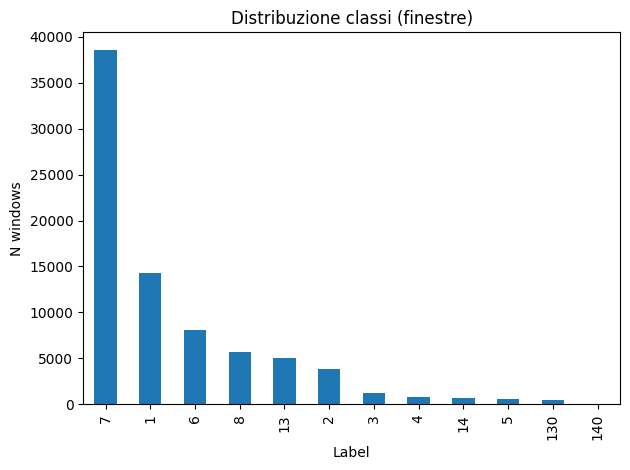

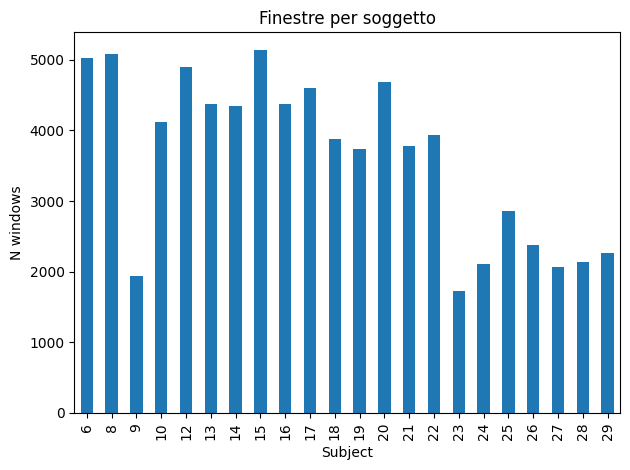

In [25]:
class_counts = y.value_counts()
subj_counts = groups.value_counts().sort_index()

display(class_counts.head(15).to_frame("n_windows"))
display(subj_counts.to_frame("n_windows").head(30))

plt.figure()
class_counts.head(20).plot(kind="bar")
plt.title("Distribuzione classi (finestre)")
plt.xlabel("Label")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

plt.figure()
subj_counts.plot(kind="bar")
plt.title("Finestre per soggetto")
plt.xlabel("Subject")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()


## 2) Split train/test per soggetto (GroupShuffleSplit)

In [26]:
from sklearn.model_selection import GroupShuffleSplit

RANDOM_STATE = 42
TEST_SIZE = 0.20  # ~4-5 soggetti su 22

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
g_train, g_test = groups.iloc[train_idx], groups.iloc[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train subjects:", sorted(g_train.unique()))
print("Test subjects:", sorted(g_test.unique()))
print("N train subjects:", g_train.nunique(), "N test subjects:", g_test.nunique())


Train: (59469, 40) Test: (19998, 40)
Train subjects: [np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
Test subjects: [np.int64(6), np.int64(8), np.int64(16), np.int64(21), np.int64(23)]
N train subjects: 17 N test subjects: 5


## 3) Modelli: LR-L2 baseline vs LDA (shrinkage)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Logistic Regression (baseline): L2 + class_weight per sbilanciamento
lr_l2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        multi_class="auto",
        class_weight="balanced",
        max_iter=2000
    ))
])

# LDA con shrinkage automatico: più robusto con feature correlate
lda_shrink = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto"
    ))
])

models = {
    "LR (L2, class_weight=balanced)": lr_l2,
    "LDA (shrinkage=auto)": lda_shrink
}

list(models.keys())


['LR (L2, class_weight=balanced)', 'LDA (shrinkage=auto)']

## 4) Cross-validation sul training (GroupKFold)

In [28]:
from sklearn.model_selection import GroupKFold, cross_validate

cv = GroupKFold(n_splits=5)

scoring = {
    "macro_f1": "f1_macro",
    "balanced_acc": "balanced_accuracy"
}

cv_rows = []
for name, pipe in models.items():
    res = cross_validate(
        pipe,
        X_train, y_train,
        groups=g_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    cv_rows.append({
        "model": name,
        "cv_macro_f1_mean": float(np.mean(res["test_macro_f1"])),
        "cv_macro_f1_std": float(np.std(res["test_macro_f1"])),
        "cv_bal_acc_mean": float(np.mean(res["test_balanced_acc"])),
        "cv_bal_acc_std": float(np.std(res["test_balanced_acc"])),
    })

cv_df = pd.DataFrame(cv_rows).sort_values("cv_macro_f1_mean", ascending=False)
display(cv_df)


,model,cv_macro_f1_mean,cv_macro_f1_std,cv_bal_acc_mean,cv_bal_acc_std
0,"LR (L2, class_weight=balanced)",0.679916,0.046606,0.817759,0.068702
1,LDA (shrinkage=auto),0.650564,0.032790,0.735269,0.082776


## 5) Fit finale su train e valutazione sul test

In [29]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

test_rows = []
preds = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred

    test_rows.append({
        "model": name,
        "test_macro_f1": float(f1_score(y_test, y_pred, average="macro")),
        "test_balanced_acc": float(balanced_accuracy_score(y_test, y_pred)),
    })

test_df = pd.DataFrame(test_rows).sort_values("test_macro_f1", ascending=False)
display(test_df)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,test_macro_f1,test_balanced_acc
0,"LR (L2, class_weight=balanced)",0.646622,0.735544
1,LDA (shrinkage=auto),0.638133,0.699357


### Report dettagliato e confusion matrix

Best model on test (by macro-F1): LR (L2, class_weight=balanced)

Classification report:
              precision    recall  f1-score   support

           1      0.976     0.684     0.804      2353
           2      0.992     0.979     0.985       373
           3      0.391     0.801     0.525       332
           4      0.358     0.698     0.473        96
           5      0.154     0.808     0.259        78
           6      0.962     0.924     0.942      2517
           7      0.996     0.995     0.995     12185
           8      0.991     0.976     0.983      1278
          13      0.908     0.847     0.876       582
          14      0.365     0.426     0.393        54
         130      0.419     0.690     0.521       142
         140      0.000     0.000     0.000         8

    accuracy                          0.934     19998
   macro avg      0.626     0.736     0.647     19998
weighted avg      0.964     0.934     0.943     19998



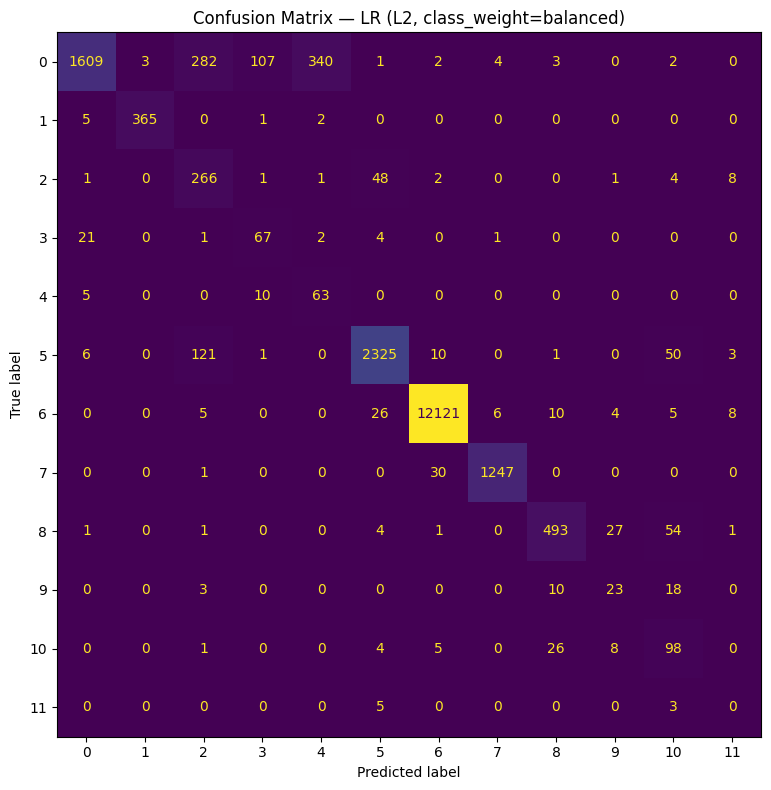

In [30]:
best_model_name = test_df.iloc[0]["model"]
print("Best model on test (by macro-F1):", best_model_name)

y_pred_best = preds[best_model_name]
print("\nClassification report:")
print(classification_report(y_test, y_pred_best, digits=3))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 8))
disp.plot(values_format="d", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
plt.show()


## 6) Note metodologiche (testo pronto per relazione)

- Lo split **per soggetto** evita leakage e misura la generalizzazione su persone non viste.
- Il test set viene usato **una sola volta** per il risultato finale.
- La GroupKFold sul training fornisce una stima più stabile (media ± deviazione standard).
- Metriche scelte (macro-F1, balanced accuracy) sono adatte a classi sbilanciate.
